# Predict TripAdvisor Rating


In [143]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./kaggle/input\sf-dst-restaurant-rating\kaggle_task.csv
./kaggle/input\sf-dst-restaurant-rating\main_task.csv
./kaggle/input\sf-dst-restaurant-rating\sample_submission.csv


In [144]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [145]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Загрузка и предварительный осмотр данных

In [146]:
DATA_DIR = './kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [147]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [148]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [149]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [150]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [151]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [152]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [153]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [155]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
49226,id_3616,Rome,"['Sushi', 'Japanese', 'Fusion']",3617.0,$$ - $$$,24.0,"[[], []]",/Restaurant_Review-g187791-d12443248-Reviews-S...,d12443248,1,4.0
11581,id_854,Rome,"['Chinese', 'Japanese', 'Seafood', 'Sushi', 'S...",855.0,$$ - $$$,399.0,"[['Super fresh quality', 'Very good'], ['07/06...",/Restaurant_Review-g187791-d5439213-Reviews-Ya...,d5439213,1,4.0
46473,id_14920,London,"['Chinese', 'Asian']",14931.0,$$ - $$$,44.0,"[['Sanbao', 'Good for quick stops'], ['10/14/2...",/Restaurant_Review-g186338-d6464421-Reviews-Sa...,d6464421,1,3.0
1018,id_1018,Athens,"['Mediterranean', 'Greek', 'Vegetarian Friendl...",283.0,$$ - $$$,208.0,"[['Amazing vegan food!!', 'Nice cafe'], ['04/1...",/Restaurant_Review-g189400-d1153486-Reviews-Ro...,d1153486,0,0.0
26624,id_4761,Barcelona,NaN,4762.0,NaN,5.0,"[['Excellent Food & Coffee'], ['07/16/2017']]",/Restaurant_Review-g187497-d7953646-Reviews-El...,d7953646,1,4.0


In [156]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# 2. Обработка и подготовка признаков
Начнем с простых признаков, чтобы потом можно было сфокусироваться на самых интересных

## 2.1 ID_TA
Id - такое ощущение, что ничего полезного для модели не содержит

## 2.2 URL_TA
Признак содержит в себе ссылку. Из примечательного только то, что ссылка содержит в себе ID_TA и id города.

## 2.3 Reviews
Признак содержит в себе пару популярных отзывов с датами. Скорее всего эти значения полезны только для быстрого рендеринга страниц сайта.

## 2.4 Number of Reviews
Есть предположение, что этот признак может быть связан рейтингом. Посмотрим на него внимательнее.

In [157]:
#Есть ли в данных пропуски
data.loc[:, ['Number of Reviews']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Number of Reviews  46800 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


In [158]:
# Пропуски есть, введем признак Number_of_Reviews_isNAN для того, чтобы сохранить информацию. Пропущенные значения заменим на 0
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [159]:
data['Number_of_Reviews_isNAN'].value_counts()

0    46800
1     3200
Name: Number_of_Reviews_isNAN, dtype: int64

In [160]:
# Пустых значений не очень много, попробуем заменить их 0
data['Number of Reviews'].fillna(0, inplace=True)

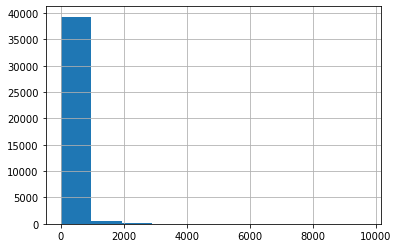

In [161]:
data['Number of Reviews'][data['sample'] == 1].hist()

## 2.5 Price Range
Предполагается, что признак будет оказывать существенное влияние на рейтинг. 

In [162]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [163]:
# Признак похож на ординальный, попробуем пронумеровать

# сохраним информацию о пропусках
data['NaN_Price Range'] = pd.isna(data['Price Range']).astype('uint8') 

# заполним значения в переменной по словарю
price_range_dic = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price_Range'] = data['Price Range'].map(lambda x: price_range_dic.get(x,x))

# заполняем пропуски наиболее частым значением (2)
data['Price_Range'] = data['Price_Range'].fillna(2)

In [164]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [165]:
data['Price_Range'][data['sample'] == 1].value_counts()

2.0    32298
1.0     6279
3.0     1423
Name: Price_Range, dtype: int64

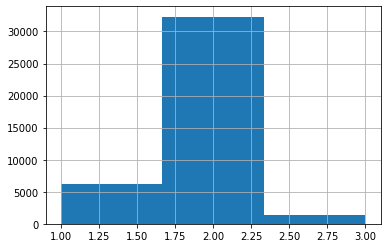

In [166]:
data['Price_Range'][data['sample'] == 1].hist(bins=3)

## 2.6 Ranking
Внутригородской рейтинг, от него должен зависеть финальный рейтинг ресторана.

In [167]:
data.loc[:, ['Ranking']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ranking  50000 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


пропусков значений нет

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DE99BF448>]],
      dtype=object)

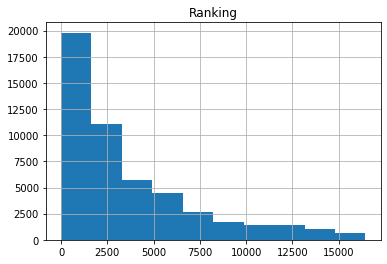

In [168]:
data.loc[:, ['Ranking']].hist()

## 2.7 Cuisine Style

In [169]:
data.loc[:, ['Cuisine Style']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Cuisine Style  38410 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [170]:
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

In [171]:
# сгенерируем новый признак число кухонь в зфведении
data['count_Cuisine_Style'] = data['Cuisine Style'].apply(lambda x: len(x.split(','))).astype('float64')

In [172]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,NaN_Price Range,Price_Range,Cuisine Style_isNAN,count_Cuisine_Style
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,2.0,0,2.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,2.0,0,5.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,2.0,0,1.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,3.0,0,5.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,3.0,0,6.0


## 2.8 City

In [173]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,NaN_Price Range,Price_Range,Cuisine Style_isNAN,count_Cuisine_Style
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,2.0,0,2.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,2.0,0,5.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,2.0,0,1.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,3.0,0,5.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,3.0,0,6.0


In [174]:
regularCity = ['Barcelona', 'Geneva', 'Hamburg', 'Krakow', 'Lyon', 'Milan', 'Munich', 'Oporto', 'Zurich']
data['Capital_City'] = data['City'].apply(lambda x: 0.0 if x in regularCity else 1.0)

In [175]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,NaN_Price Range,Price_Range,Cuisine Style_isNAN,count_Cuisine_Style,Capital_City
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,2.0,0,2.0,1.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,2.0,0,5.0,1.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,2.0,0,1.0,1.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,3.0,0,5.0,1.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,3.0,0,6.0,1.0


In [176]:
cities_population = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 'Berlin' : 6010, 'Milan' : 1366, 
                     'Rome' : 2872, 'Prague' : 1308, 'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                     'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 'Budapest' : 1752, 'Warsaw' : 1764,
                     'Dublin' : 553, 'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 'Zurich' : 415, 'Oporto' : 240, 
                     'Geneva' : 201, 'Krakow' : 769, 'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 'Luxembourg' : 119, 'Ljubljana' : 284}
data['Сity_Population'] = data.apply(lambda row: cities_population[row['City']], axis = 1)

In [177]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,NaN_Price Range,Price_Range,Cuisine Style_isNAN,count_Cuisine_Style,Capital_City,Сity_Population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,2.0,0,2.0,1.0,2206
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,2.0,0,5.0,1.0,643
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,2.0,0,1.0,1.0,513
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,3.0,0,5.0,1.0,8908
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,3.0,0,6.0,1.0,426


In [178]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,NaN_Price Range,Price_Range,Cuisine Style_isNAN,count_Cuisine_Style,Capital_City,Сity_Population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,2.0,0,2.0,1.0,2206
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,2.0,0,5.0,1.0,643
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,2.0,0,1.0,1.0,513
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,3.0,0,5.0,1.0,8908
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,3.0,0,6.0,1.0,426


In [179]:
restorantsPerCityCount = data['City'].value_counts(ascending=False)
data['restorants_Per_City_Count'] = data['City'].apply(lambda x: restorantsPerCityCount[x])
data['norm_Population_on_Rest'] = data['Сity_Population']/data['restorants_Per_City_Count']

# EDA 

### Посмотрим распределение признака

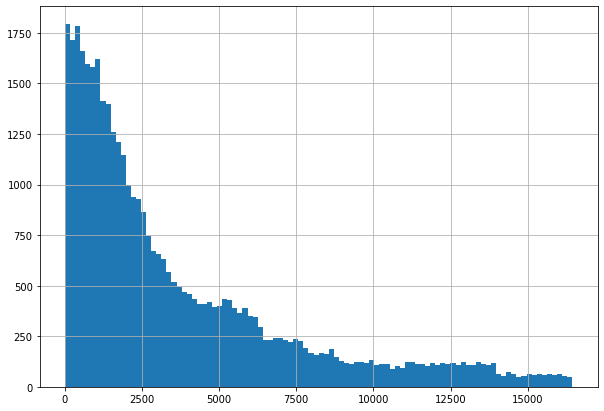

In [180]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

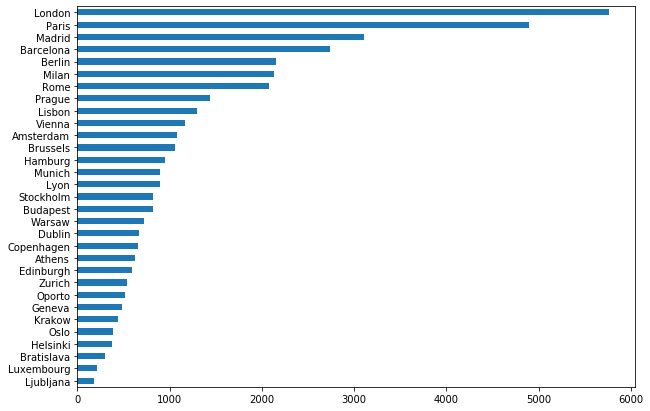

In [181]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

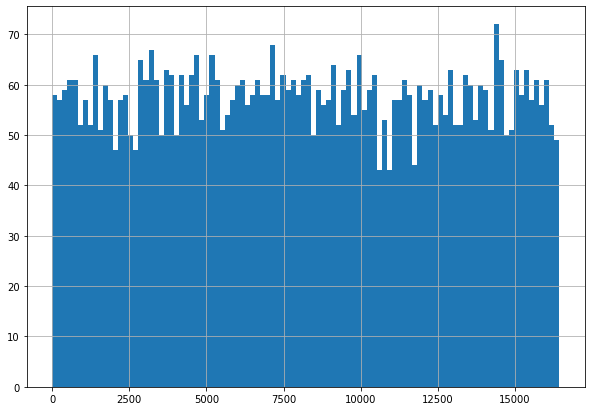

In [182]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

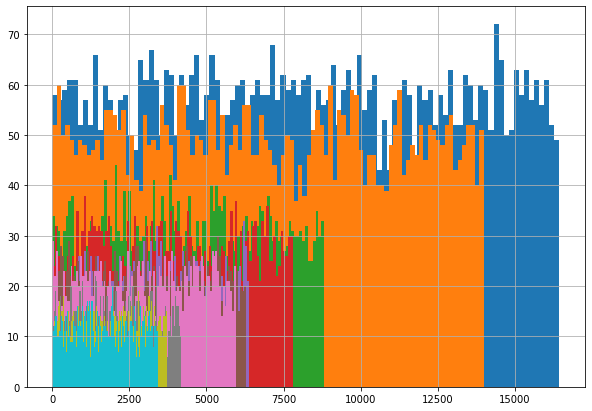

In [183]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [184]:
rankingMeanPerCity = data.groupby(['City'])['Ranking'].mean()
data['ranking_Mean_Per_City'] = data['City'].apply(lambda x: rankingMeanPerCity[x])

restorantCountPerCity = data['City'].value_counts(ascending=False)

data['restorant_Count_Per_City'] = data['City'].apply(lambda x: restorantCountPerCity[x])
data['norm_Ranking_Per_City'] = (data['Ranking'] - data['ranking_Mean_Per_City']) / data['restorant_Count_Per_City']

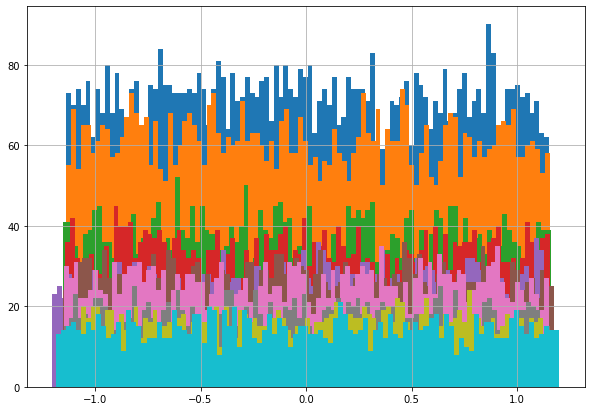

In [185]:
for x in (data['City'].value_counts())[0:10].index:
    data['norm_Ranking_Per_City'][data['City'] == x].hist(bins=100)
plt.show()

In [186]:
rankingMaxPerCity = data.groupby(['City'])['Ranking'].max()
data['ranking_Max_Per_City'] = data['City'].apply(lambda x: rankingMaxPerCity[x])

data['norm_Ranking_Per_City2'] = (data['Ranking'] - data['ranking_Max_Per_City']) / data['ranking_Max_Per_City']

In [187]:
for x in (data['City'].value_counts())[0:10].index:
    data['norm_Ranking_Per_City2'][data['City'] == x].hist(bins=100)
plt.show()

KeyError: 'norm_Ranking_Per_City2'

### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
data = pd.get_dummies(data, columns=['City',], dummy_na=True)

In [ ]:
data.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review', 'Сity_Population', 'restorants_Per_City_Count'], axis=1, inplace=True, errors='ignore')

#### Запускаем и проверяем что получилось

In [ ]:
data.sample(10)

In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
